In [1]:
# Imports
import wikipedia
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import re
import requests
from bs4 import BeautifulSoup

In [164]:
# From https://stackoverflow.com/questions/54170998/crawl-the-first-paragraph-link-in-wiki
def get_first_link(page_url):
    # Get page
    response = requests.get(page_url)
    html = response.text
    soup = BeautifulSoup(html, "html.parser")
    try:
        paragraphs = soup.find(id='mw-content-text').find(class_="mw-parser-output").find_all('p', recursive=False)
        link_list = []

        # Help links RegEx
        help_link_regex = re.compile('^/wiki/Help:')

        # Fails on languages for some reason but this works instead
        if "_language" in page_url:
            filtered_paragaphs = [p for p in paragraphs if len(p) > 1]
            p1_links = filtered_paragaphs[0].find_all("a", recursive=False)
            
            first_link = p1_links[0].get('href')
            if first_link==None:
                first_link = p1_links[1].get('href')
            return first_link
            
        for p in paragraphs:
            p_links = p.find_all("a", recursive=False)

            for link in p_links:
                # Leave them out if they match the previous RegEx
                if not help_link_regex.match(link.get('href')):
                    # print(link.get('href'))
                    link_list.append(link.get('href'))
                    break

        # Get the first link and return it
        try:
            first_link = link_list[0]
            return first_link
        except IndexError:
            original_name = page_url.lstrip("https://en.wikipedia.org/wiki/")
            if len(wikipedia.page(original_name).links) == 0:
                return "DEAD END: " + original_name
            else:
                return "!FAIL!: " + original_name
    except AttributeError:
        original_name = page_url.lstrip("https://en.wikipedia.org/wiki/")
        return "!FAIL!: " + original_name
    except TypeError:
        original_name = page_url.lstrip("https://en.wikipedia.org/wiki/")
        return "!FAIL!: " + original_name
            

In [57]:
# Create Graph
G = nx.DiGraph()

# Add Philosophy as the first node
G.add_node("philosophy")

# Starting page, can be anything
seed_page = "Georgetown University"
is_root = True

# These start as the same thing
root_page = seed_page

# Create first url
first_page_url = "https://en.wikipedia.org/wiki/" + seed_page
old_page = seed_page
seen_pages = ["philosophy"]

# List of fails
fails = []

# Not connected to philosophy
disconnects = []

In [167]:
def wiki_random_page(seen_pages):
    already_seen_page = True

    while already_seen_page:
        random_page = wikipedia.random()
        
        if random_page in seen_pages:
            already_seen_page = True
            continue

        elif "list of " in random_page.lower() or "list_of" in random_page.lower():
            already_seen_page = True
        
        elif '(disambiguation)' in random_page.lower():
            already_seen_page = True

        else:
            page_url = "https://en.wikipedia.org/wiki/" + root_page
            already_seen_page = False

    return random_page, page_url

In [175]:
# # Random seed for restarts
# Starting page
seed_page, first_page_url = wiki_random_page(G.nodes)
seen_pages = G.nodes
is_root = True

# These start as the same thing
root_page = seed_page

# Create first url
old_page = seed_page

In [170]:
def network_expander(G, page_url, seen_pages, is_root, fails, disconnects, new_pages=100):
    for i in tqdm(range(new_pages), desc="Finding Paths", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}", colour="#336699", ncols=75):
        # Get the first link
        full_first_link = get_first_link(page_url=page_url)

        # If it fails, find try a new random page
        if "!FAIL!: " in full_first_link:
            # We don't need to care if it was a root page
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)

            # If it as nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append([seen_pages[-1], first_link])
                # print(full_first_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_first_link = get_first_link(page_url=page_url)
                
        elif "DEAD END: " in full_first_link:
            print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True
            
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        # Add edge if there is one
        if not is_root:
            G.add_edge(old_page, first_link)
        

        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Page did a self loop! Not connected to philosophy
        elif first_link == root_page:
            print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link
            is_root = False

    return G, seen_pages, fails, disconnects,


In [177]:
G, seen_pages, fails, disconnects = network_expander(
    G,
    page_url=first_page_url,
    seen_pages=seen_pages,
    is_root=True,
    fails=fails,
    disconnects=disconnects,
    new_pages=1000,
)


Finding Paths: 100%|████████████████████████████████████████████| 1000/1000


In [178]:
first_link_path = './data/first-links.gml'
nx.write_gml(G, first_link_path)

In [89]:
G = nx.read_gml(first_link_path)

Look into core decompositions for displaying the network. Force directed would be better but is slow. 
Switch it to a directed graph.

In [199]:
# ------------------------------
# NETWORK PLOTTING FUNCTION
# ------------------------------
def plot_network(G, node_color="degree", layout="random"):
    # INITALIZE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)

    # NODE COLORS
    cmap = plt.cm.get_cmap("Greens")

    # DEGREE
    if node_color == "degree":
        centrality = list(dict(nx.degree(G)).values())

    # BETWENNESS
    if node_color == "betweeness":
        centrality = list(dict(nx.betweenness_centrality(G, endpoints="philosophy")).values())

    # CLOSENESS
    if node_color == "closeness":
        centrality = list(dict(nx.closeness_centrality(G)).values())

    # NODE SIZE CAN COLOR
    node_colors = [cmap(u / (0.01 + max(centrality))) for u in centrality]
    node_sizes = [10000 * u / (0.001 + max(centrality)) for u in centrality]

    scaled_node_sizes = [size if size > 3000 else 100 for size in node_sizes]

    scale = [size / max(node_sizes) for size in scaled_node_sizes]

    # POSITIONS LAYOUT
    N = len(G.nodes)
    if layout == "spring":
        # pos=nx.spring_layout(G,k=50*1./np.sqrt(N),iterations=100)
        pos = nx.spring_layout(G, scale=scale)

    if layout == "random":
        pos = nx.random_layout(G)

    if layout == "spiral":
        pos = nx.spiral_layout(G, scale=scale)

    if layout == "spectral":
        pos = nx.spectral_layout(G, scale=scale)
    
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)

    # PLOT NETWORK
    nx.draw(
        G,
        edgecolors="black",
        node_color=node_colors,
        node_size=scaled_node_sizes,
        pos=pos,
        with_labels=True
    )

    plt.show()


# G.remove_edges_from(nx.selfloop_edges(G))
# plot_network(nx.k_core(G, 50), node_color="degree", layout="spectral")


In [179]:
degree_dict = dict(G.in_degree())

# Create a dataframe with nodes and their degrees
df_nodes = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Degree'])

# Sort the dataframe by degree in descending order
df_nodes_sorted = df_nodes.sort_values(by='Degree', ascending=False)

df_nodes_sorted.head(10)

,Degree
biology,13
physics,11
sport,11
french_language,10
help:pronunciation_respelling_key,10
ancient_greek_language,10
language,9
language_family,9
team_sport,8
german_language,8


In [180]:
fails

[['!fail!: half time (disambiguation)', '!fail!: half time (disambiguation)'],
 ['ndex.php?title=west_old_turkic&action=edit&redlink=1',
  'ndex.php?title=west_old_turkic&action=edit&redlink=1'],
 ['!fail!: wahlquist', '!fail!: wahlquist'],
 ['!fail!: barry johnson (artist)', '!fail!: barry johnson (artist)'],
 ['!fail!: dewey martin', '!fail!: dewey martin'],
 ['!fail!: whisper not', '!fail!: whisper not'],
 ['list_of_legal_abbreviations', 'list_of_legal_abbreviations'],
 ['!fail!: widespread panic discography',
  '!fail!: widespread panic discography'],
 ['!fail!: david cracknell', '!fail!: david cracknell'],
 ['!fail!: beyhan sultan', '!fail!: beyhan sultan'],
 ['!fail!: 3mw', '!fail!: 3mw'],
 ['!fail!: sideline', '!fail!: sideline'],
 ['!fail!: tchórzew (disambiguation)', '!fail!: tchórzew (disambiguation)'],
 ['lee_ritenour', 'lee_ritenour'],
 ['!fail!: home is where the heart is', '!fail!: home is where the heart is'],
 ['!fail!: domingo garcía', '!fail!: domingo garcía'],
 ['!fa

In [236]:
def fail_fixer(G, fail, next_link, seen_pages):
    clean_name = fail.lstrip("!fail!: ")
    G = nx.relabel_nodes(G, {fail:clean_name})
    G.add_node(next_link)
    G.add_edge(clean_name, next_link)

    page_url = "https://en.wikipedia.org/wiki/" + next_link

    if next_link != "philosophy":
        philosophy_page = False
        old_page = next_link
    else: philosophy_page = True

    while not philosophy_page:
        full_first_link = get_first_link(page_url=page_url)
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        G.add_edge(old_page, first_link)
        

        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            philosophy_page = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            philosophy_page = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link

    # fails = fails[True if f[0]!=fail else False for f in fails]

    return G, seen_pages

In [242]:
G, seen_pages = fail_fixer(G, fail='!fail!: crime city', next_link="crime_film", seen_pages=seen_pages)

In [243]:
nx.shortest_path(G, "crime city","philosophy")

['crime city',
 'crime_film',
 'film_genre',
 'genre',
 'french_language',
 'romance_languages',
 'modern_language',
 'language',
 'communication',
 'information',
 'abstraction',
 'rule_of_inference',
 'philosophy_of_logic',
 'philosophy']

In [181]:
get_first_link("https://en.wikipedia.org/wiki/1604_in_France")

'!FAIL!: 1604_in_France'

In [182]:
disconnects

[]

In [183]:
# Calculate the degrees of each node
degrees = dict(G.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by degree:
biology: 14
sport: 12
physics: 12
ancient_greek_language: 11
french_language: 11
help:pronunciation_respelling_key: 11
language: 10
language_family: 10
german_language: 9
team_sport: 9


In [185]:
neighbors = [n[0] for n in list(G.in_edges("philosophy"))]
neighbor_degrees = [G.in_edges(n) for n in neighbors]
neighbors

['awareness', 'philosophy_of_logic', 'aesthetics']

In [63]:
# Calculate the degrees of each node
betweeness_centrality = dict(nx.betweenness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by betweeness centrality:")
for node, betweeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {betweeness_centrality}")

Top nodes by betweeness centrality:
language: 0.00207043164802662
communication: 0.0017458997031970507
greek_language: 0.0015646342340121804
information: 0.001443961754526502
modern_greek: 0.0014275297573199414
dialect: 0.0012893982808022924
classical_language: 0.0012365077897936757
latin: 0.0011831037988723544
abstraction: 0.001099916813014142
ancient_greek_language: 0.0009181378439165666


In [64]:
# Calculate the degrees of each node
closeness_centrality = dict(nx.closeness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by closeness centrality:")
for node, closeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {closeness_centrality}")

Top nodes by closeness centrality:
philosophy: 0.08059251819021965
language: 0.06442625785454673
communication: 0.058029448439128314
information: 0.054683025688825396
abstraction: 0.05048850837672131
awareness: 0.04649056210506289
rule_of_inference: 0.04607536739523234
knowledge: 0.043578815927628335
philosophy_of_logic: 0.04238597549521519
science: 0.04029198319175359


In [194]:
distance_from_phil = []
path_to_phil = []
nodes = []
for node in G.nodes:
    try:
        shortest_path = nx.shortest_path(G, node, "philosophy")
        shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
        nodes.append(node)
        distance_from_phil.append(shortest_path_length)
        path_to_phil.append(shortest_path)
    except nx.NetworkXNoPath:
        shortest_path = np.NAN
        shortest_path_length = np.NAN
        continue


# nodes  = [n for n in G.nodes]
df = pd.DataFrame(
    {"node": nodes, "distance": distance_from_phil, "shortest_path": path_to_phil}
)
print("AVERAGE DISTANCE TO PHILOSOPHY: ", np.mean(distance_from_phil))
df.sort_values("distance", inplace=True)
df.reset_index(inplace=True)
df.pop("index")
nodes = df["node"]
distances = df["distance"]
paths = df["shortest_path"]
print(
    "FURTHEST NODE: ",
    nodes[len(nodes) - 1],
    " is ",
    distances[len(distances) - 1],
    " pages away with a path of: ",
    paths[len(distances) - 1],
)
print(
    "THERE ARE "
    + str(
        sum([True if distance == max(distances) else False for distance in distances])
    )
    + " paths with a distance of "
    + str(max(distances))
)


AVERAGE DISTANCE TO PHILOSOPHY:  11.465944272445821
FURTHEST NODE:  arkansas_highway_326  is  22  pages away with a path of:  ['arkansas_highway_326', 'list_of_arkansas_state_highways', 'state_highway', 'route_number', 'alphanumeric', 'alphabetical', 'character_string', 'computer_programming', 'computation', 'arithmetic', 'ancient_greek_language', 'greek_language', 'modern_greek', 'dialect', 'latin', 'classical_language', 'language', 'communication', 'information', 'abstraction', 'rule_of_inference', 'philosophy_of_logic', 'philosophy']
THERE ARE 2 paths with a distance of 22


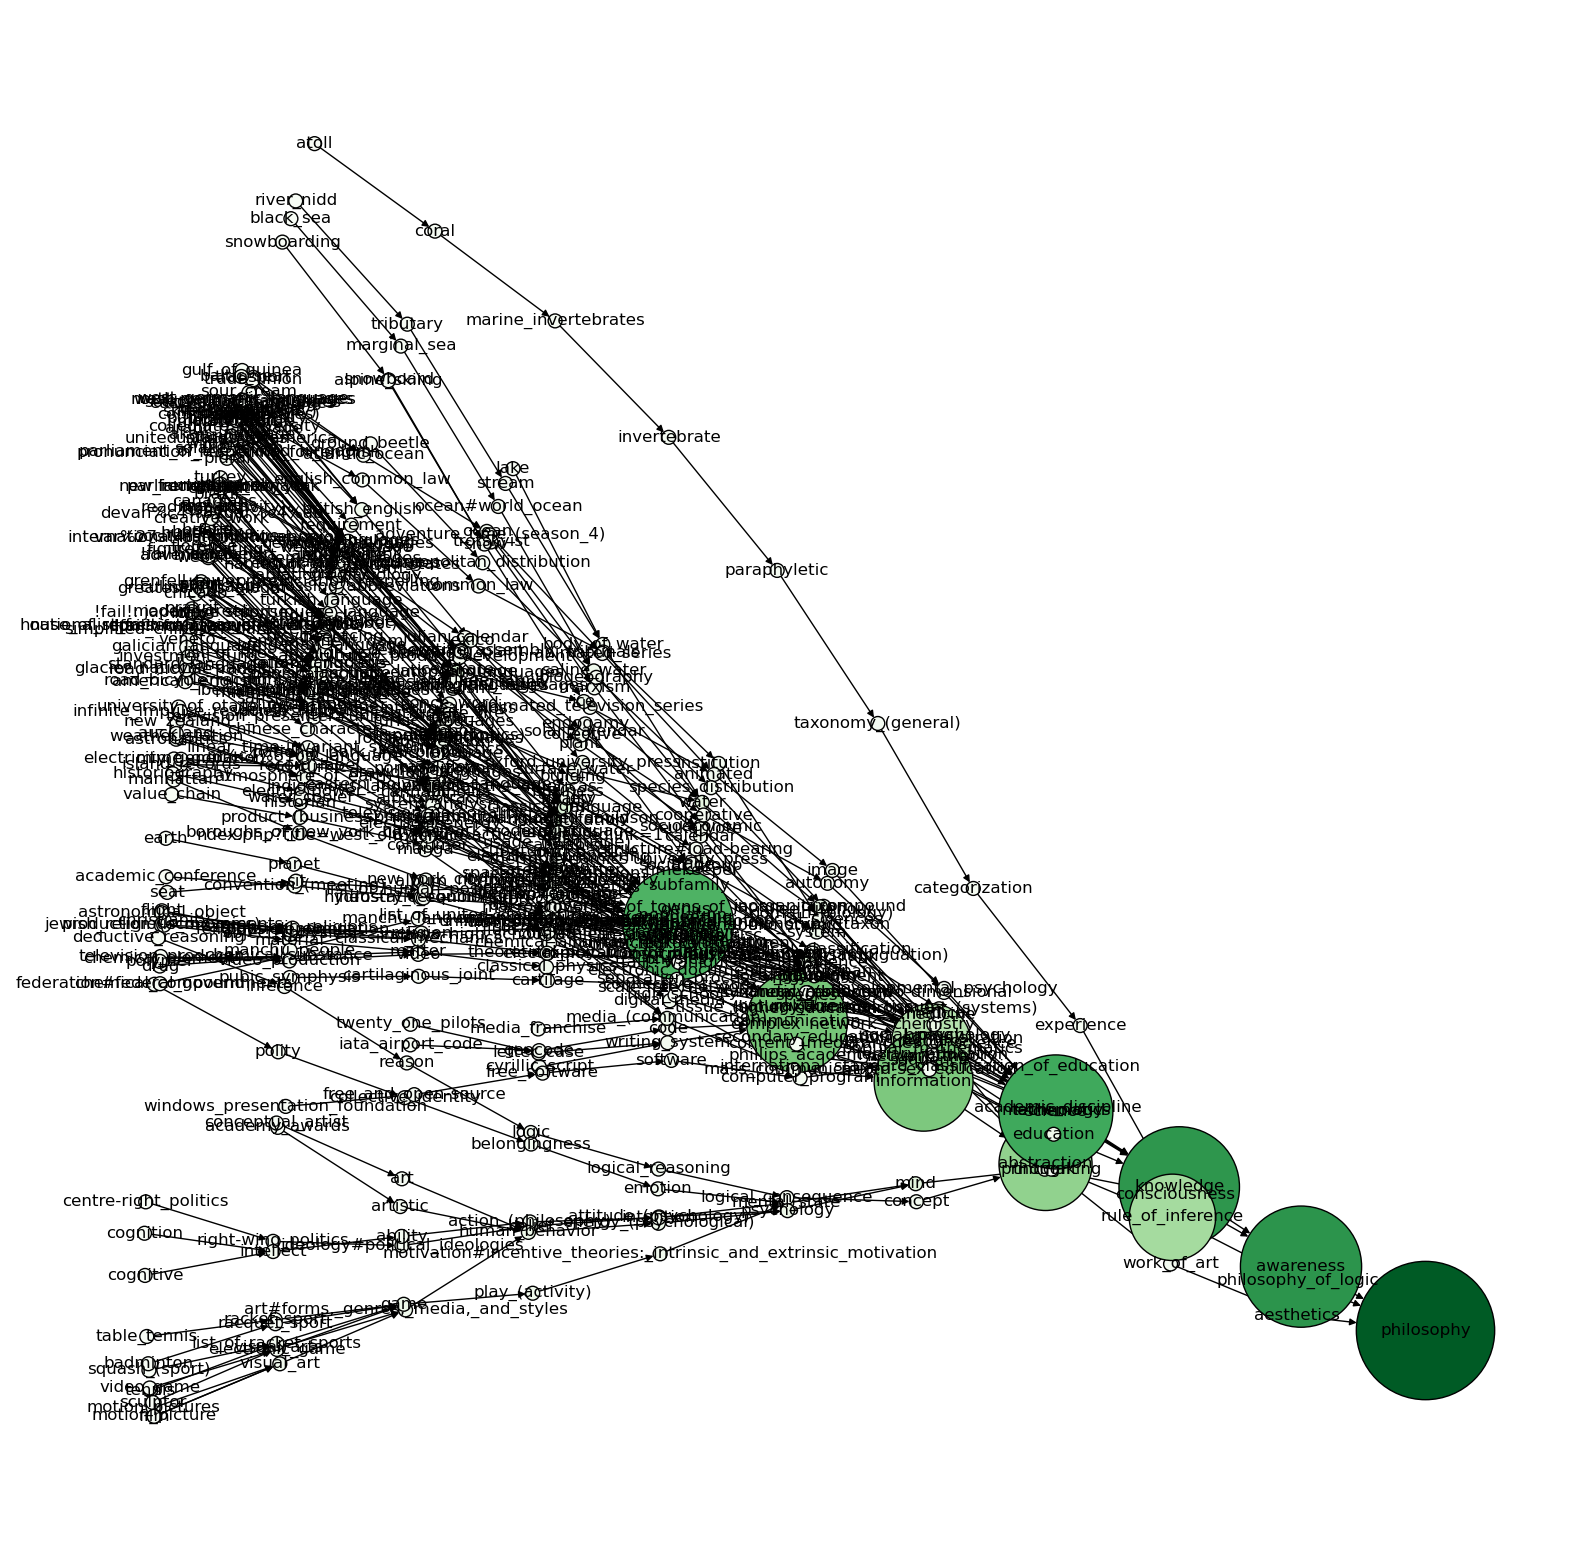

In [244]:
ten_away = df[df['distance'] <= 10]

subgraph = G.subgraph(ten_away['node'])

plot_network(subgraph, node_color="closeness", layout="kamada_kawai")

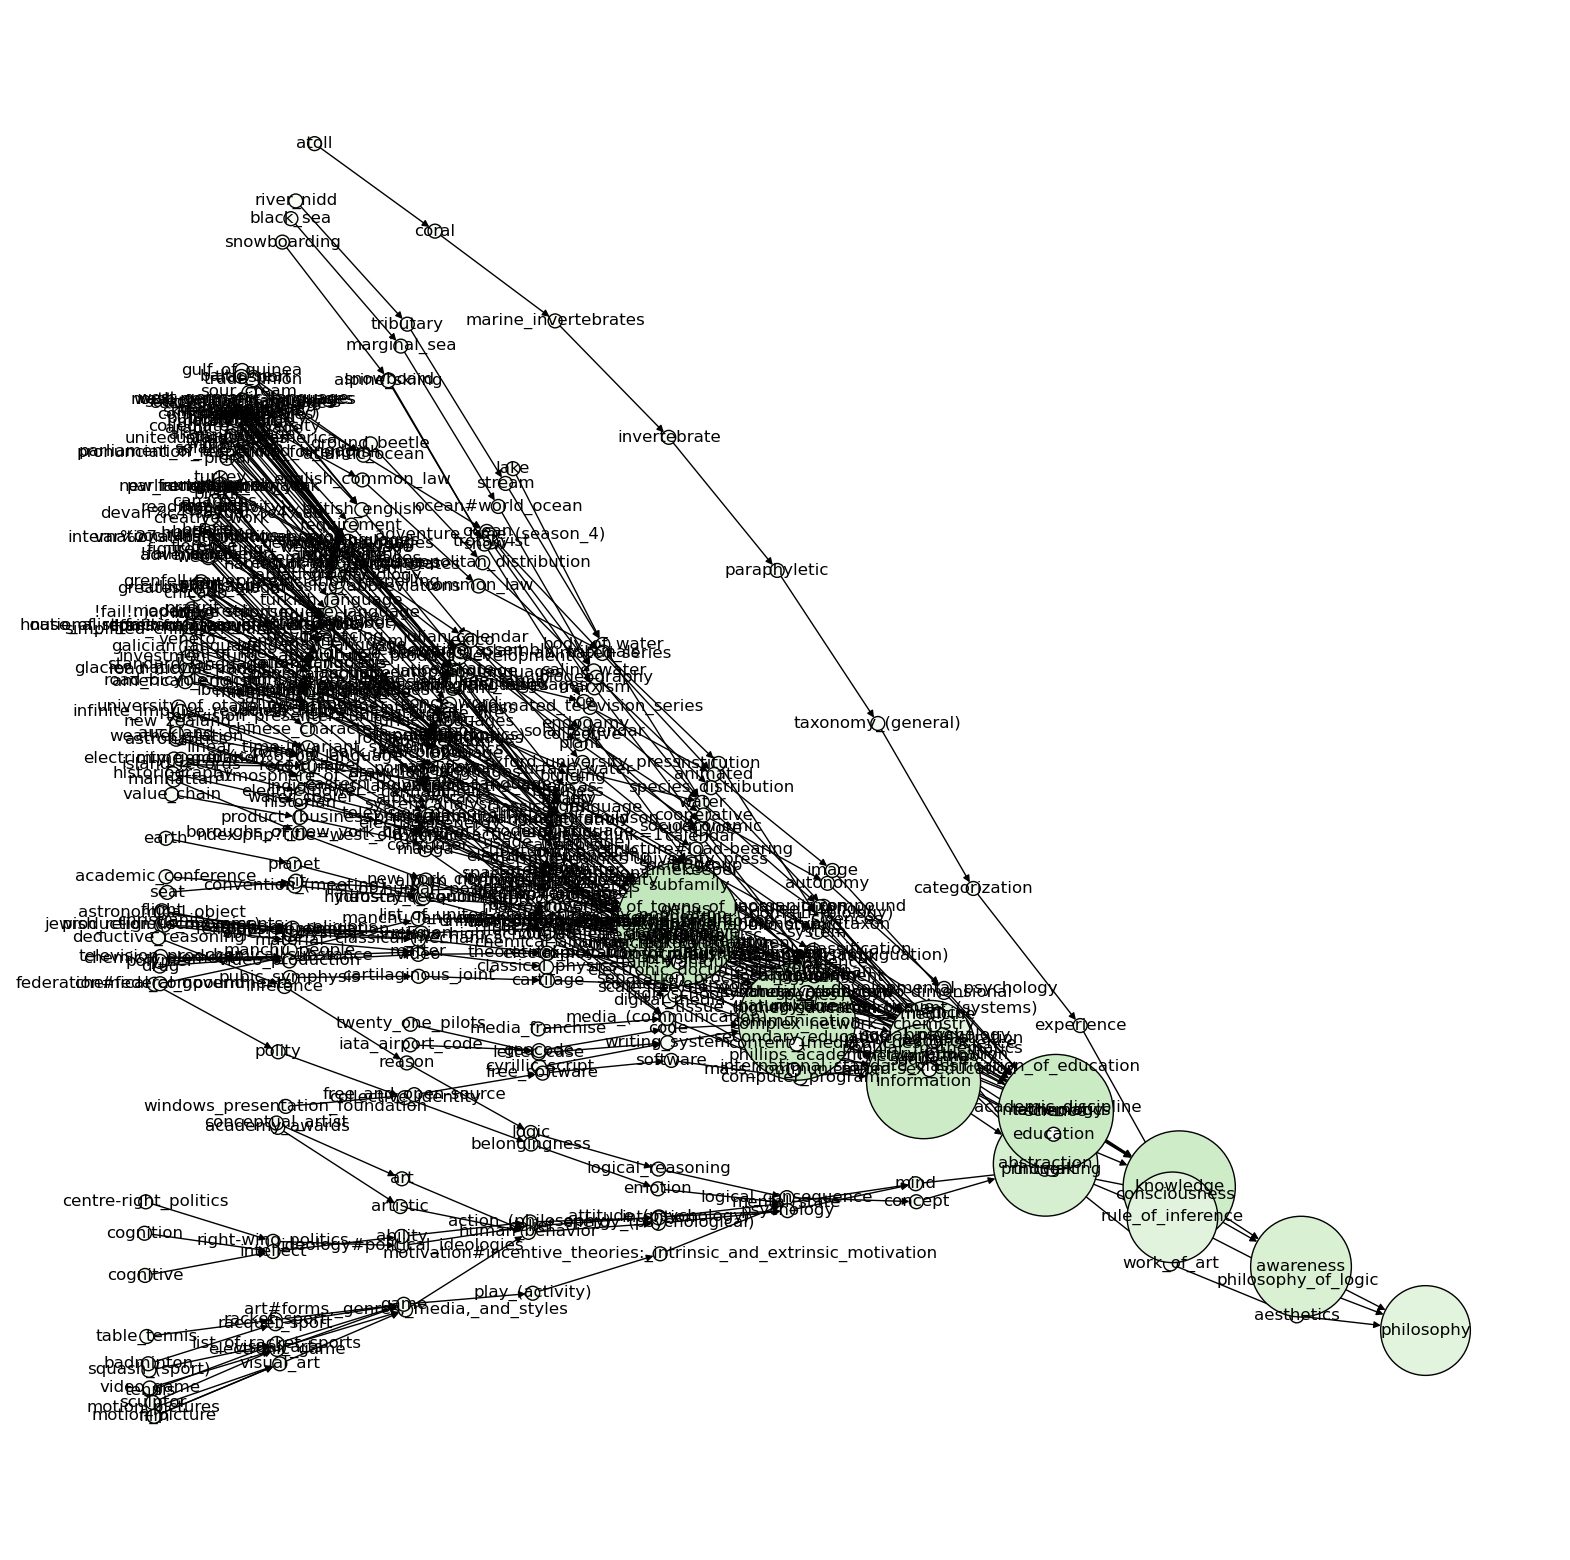

In [201]:
plot_network(subgraph, node_color="betweeness", layout="kamada_kawai")

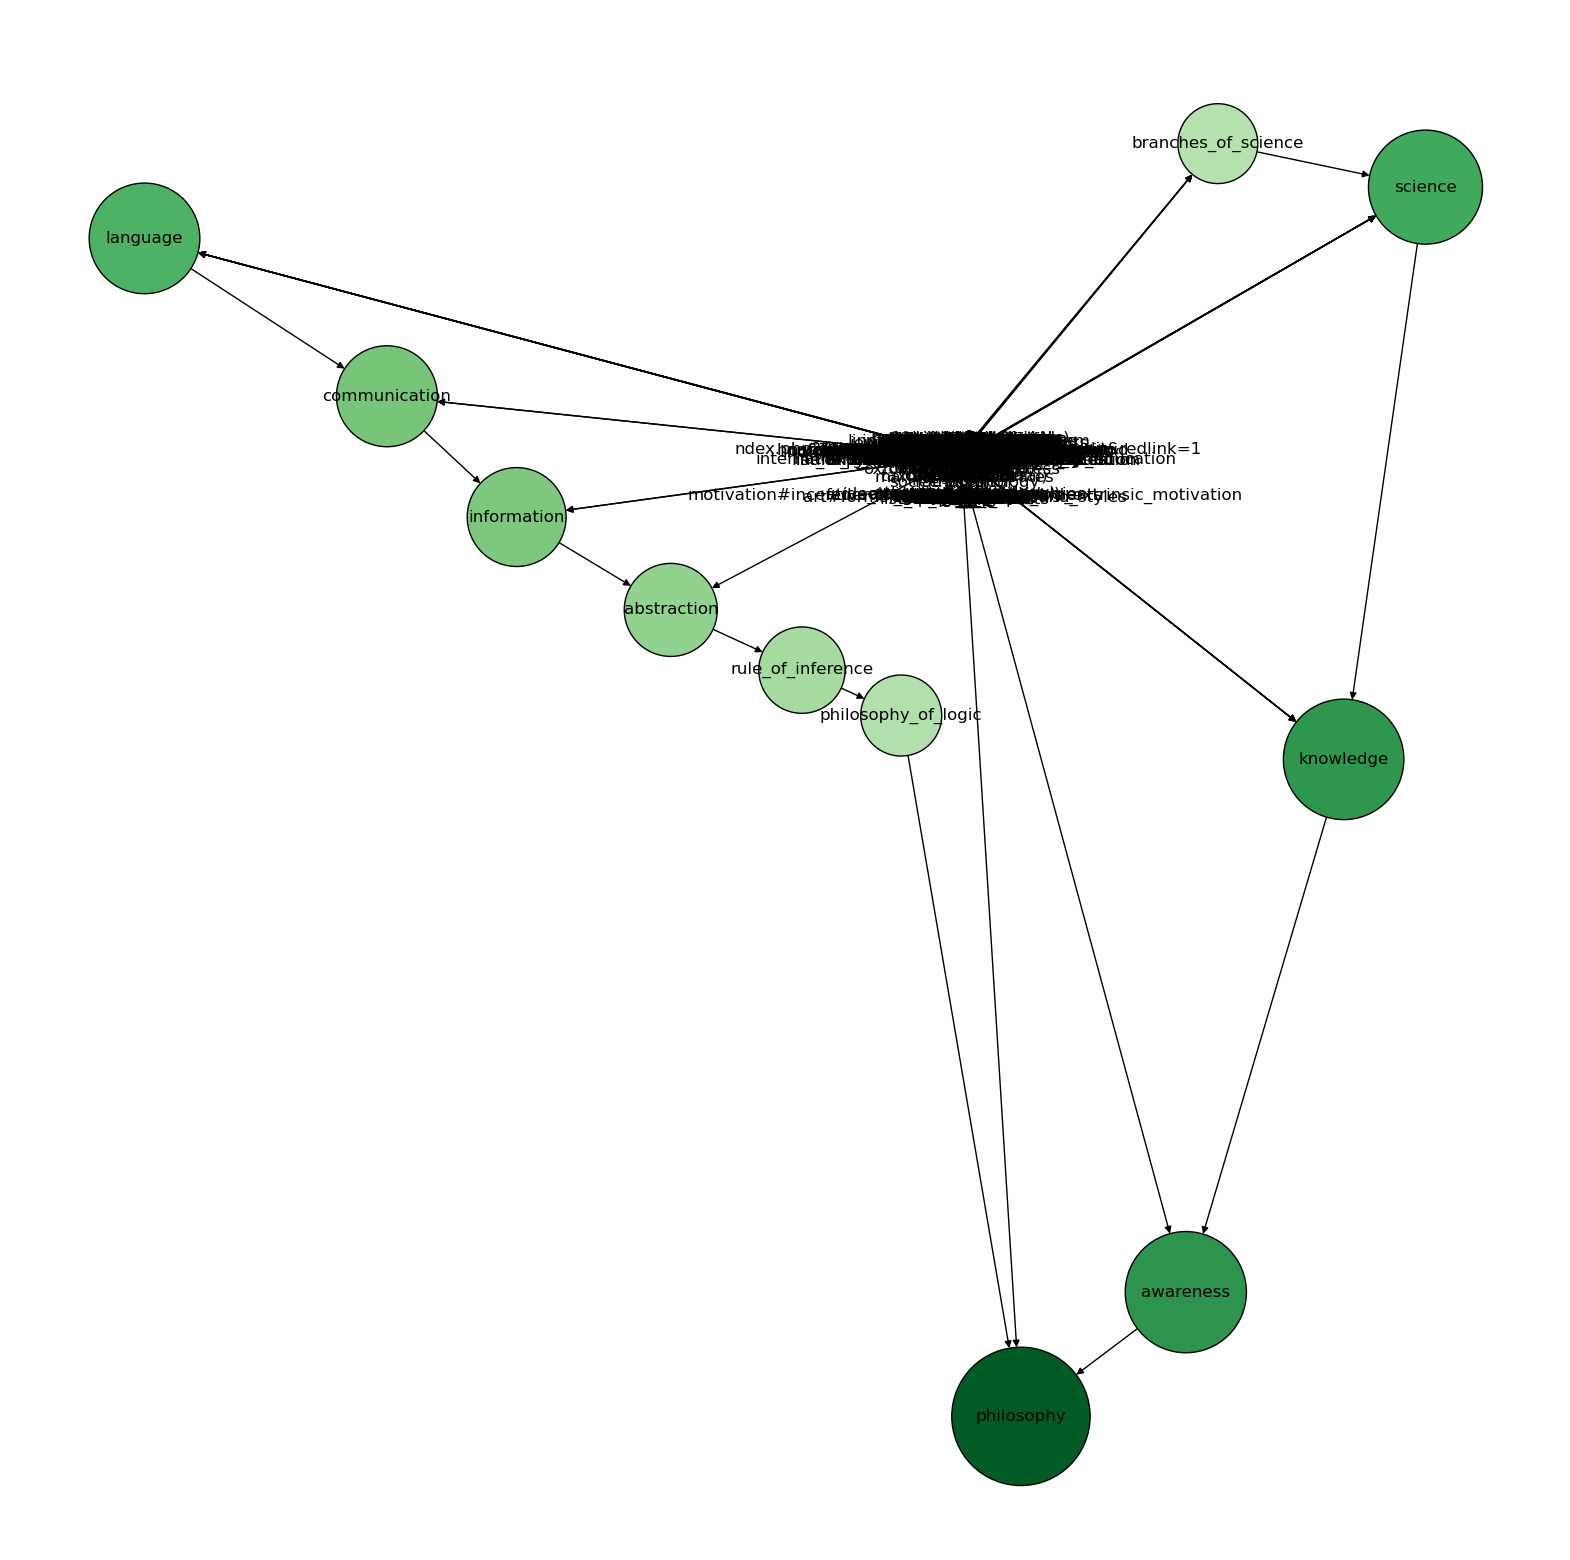

In [245]:
plot_network(subgraph, node_color="closeness", layout="spectral")

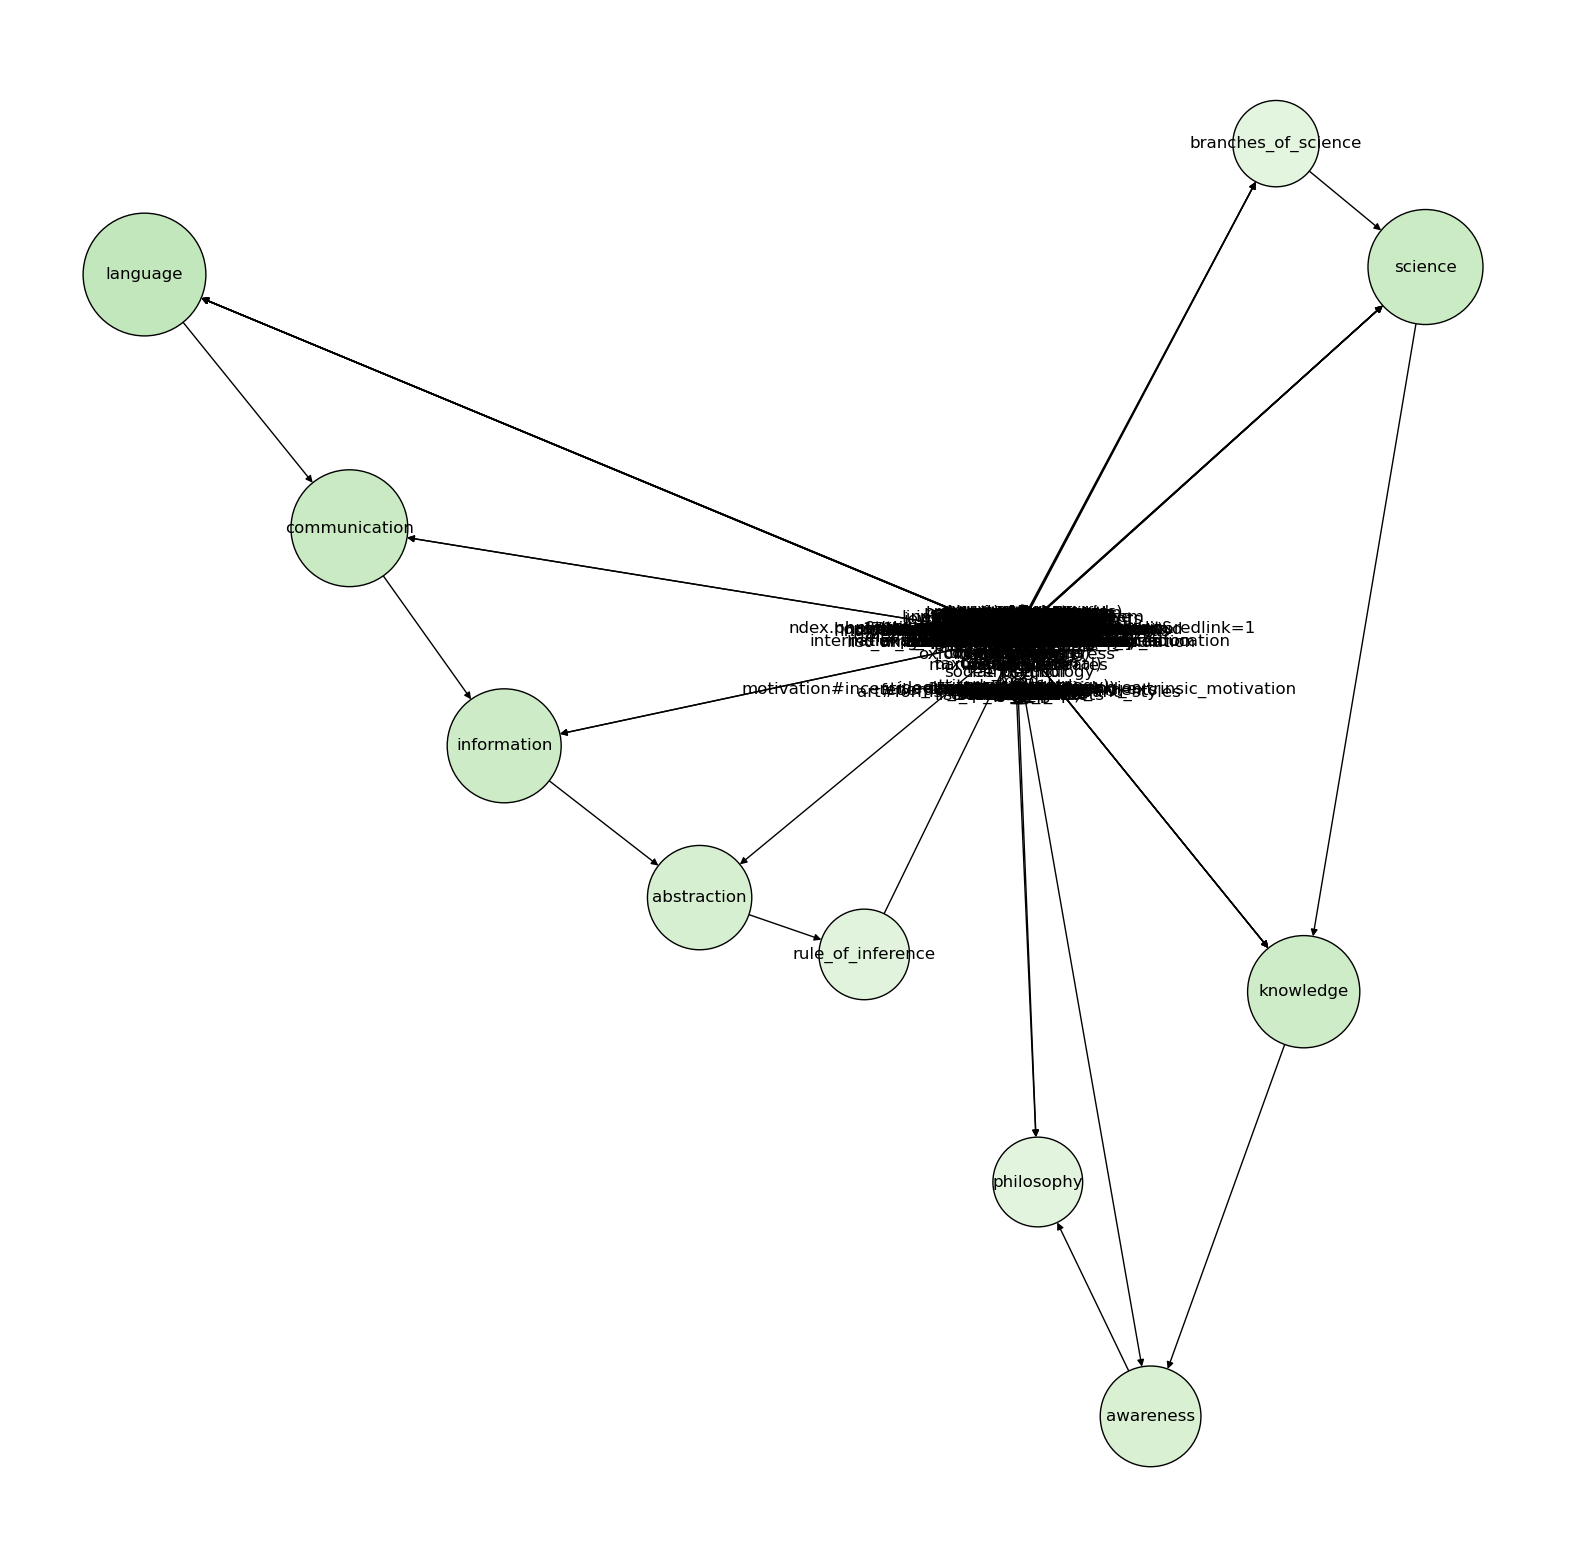

In [246]:
plot_network(subgraph, node_color="betweeness", layout="spectral")

In [188]:
path_appearances = []
for node in G.nodes:
    count = 0
    for path in paths:
        if node in path:
            count +=1
    
    path_appearances.append(count)

path_count_df = pd.DataFrame({"node":G.nodes, "appearances":path_appearances})
path_count_df = path_count_df.sort_values("appearances", ascending=False)
path_count_df.reset_index(inplace=True)
path_count_df.pop("index")

# Remove philosophy
path_count_df = path_count_df[1:]
path_count_df.head(80)

,node,appearances
1,philosophy_of_logic,717
2,rule_of_inference,716
3,abstraction,715
4,information,704
5,communication,681
...,...,...
76,environment_(systems),24
77,intellect,23
78,sociolinguistics,23
79,system,23


In [189]:
path_appearances = []
for path in np.unique(paths):
    count = sum([True if path==path_i else False for path_i in paths])
    path_appearances.append(count)

paths_df = pd.DataFrame({"path":np.unique(paths), "appearances":path_appearances})
paths_df = paths_df.sort_values("appearances", ascending=False)
paths_df.reset_index(inplace=True)
paths_df.pop("index")
paths_df

,path,appearances
0,"[!fail!: 1960 academy awards, acrobatics, anci...",1
1,"[physical_activity, exercise, human_body, huma...",1
2,"[paralympic_games, disability, cognitive_disab...",1
3,"[paraglider, adventure_sport, physical_activit...",1
4,"[papiamento_language, dutch_language, west_ger...",1
...,...,...
1287,"[environment_(systems), science, knowledge, aw...",1
1288,"[english_language, west_germanic_language, ger...",1
1289,"[english_land_law, real_property, english_comm...",1
1290,"[english_in_the_commonwealth_of_nations, engli...",1


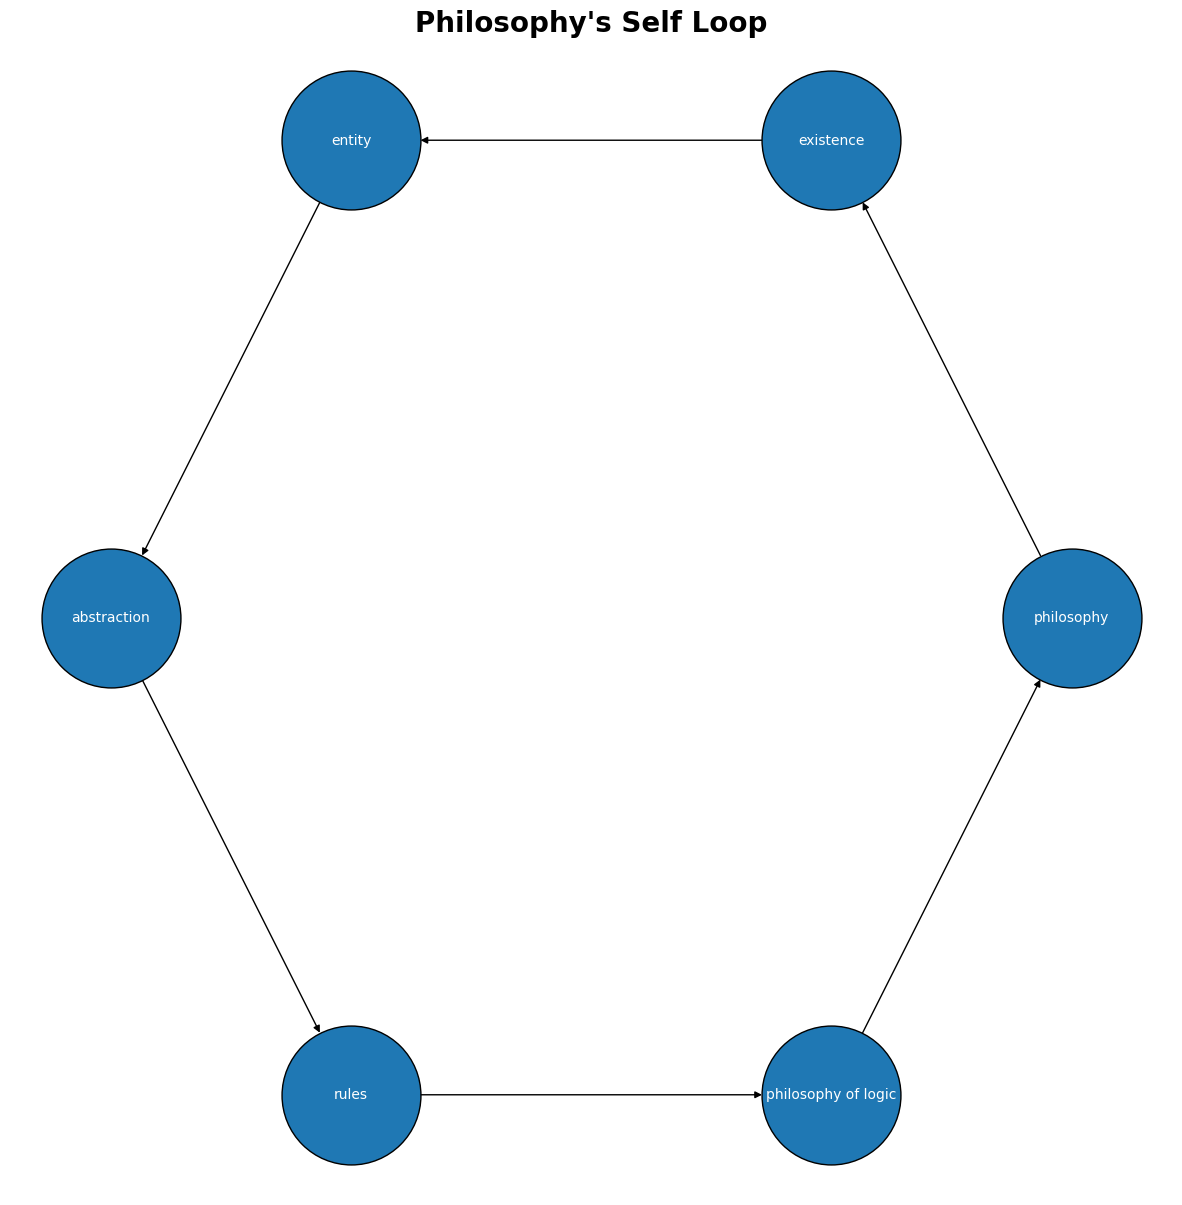

In [40]:
path = ['philosophy','existence', 'entity', 'abstraction', 'rules', 'philosophy of logic', 'philosophy']
G = nx.DiGraph()

for i, page_name in enumerate(path):
    G.add_node(page_name)
    if i == 0:
        pass
    else: 
        G.add_edge(old_page, page_name)
        old_page = page_name

fig, ax = plt.subplots()
fig.set_size_inches(15, 15)

pos = nx.circular_layout(G)
fig = nx.draw(G,
    with_labels=True,
    edgecolors="black",
    font_color="white",
    node_size=10000,
    pos=pos,
    font_size=10) 

plt.title("Philosophy's Self Loop", fontweight='bold', fontsize=20)
plt.savefig('../slides/Images/phil-loop.png')
plt.show()